# Proximal Policy Optimization with Brax

Proximal Policy Optimization (PPO) is an on-policy, model-free Reinforcement Learning algorithm.

As a simulator of choice we use [Brax](https://github.com/google/brax), since it is written in JAX and supports several continuous-control environments. Also, it is blazingly fast!

For particular details about PPO implementation, you can read the original [PPO paper from arxiv](https://arxiv.org/abs/1707.06347) or [this awesome article](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details)


!!! cite "Reference"
```bibtex
@misc{schulman2017proximal,
      title={Proximal Policy Optimization Algorithms},
      author={John Schulman and Filip Wolski and Prafulla Dhariwal and Alec Radford and Oleg Klimov},
      year={2017},
      eprint={1707.06347},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}
```


Include all the libraries we need. In fact, we have only three dependencies: JAX, Brax and Equinox.

In [1]:
# JAX, Autograd and XLA
# GitHub: https://github.com/google/jax
import jax
from jax import lax
from jax import random as jr
from jax import numpy as jnp
from jax import tree_util as jtu

# Optax, optimizers for machine learning in JAX
# GitHub: https://github.com/google-deepmind/optax
import optax

# Equinox, awesome library for (awesome) neural networks in JAX
# GitHub: https://github.com/patrick-kidger/equinox;
# Arxiv: https://arxiv.org/abs/2111.00254
import equinox as eqx

# Brax, vectorized continuous RL environments, in JAX
# GitHub: https://github.com/google/brax;
# Arxiv: https://arxiv.org/abs/2106.13281
from brax import envs

from collections.abc import Callable

A few utility functions that are similar to other Equinox filtered wrappers.

In the implementation we are constantly using lax.scan, and hence wrapping it, so that it can consume partially-static PyTrees seems nice.

In [2]:
# A few of utility functions, that automatically partition PyTrees
@eqx.filter_jit
def filter_scan(f: Callable, init, xs, *args, **kwargs):
    """Same as lax.scan, but allows to have eqx.Module in carry"""
    init_dynamic_carry, static_carry = eqx.partition(init, eqx.is_array)

    def to_scan(dynamic_carry, x):
        carry = eqx.combine(dynamic_carry, static_carry)
        new_carry, out = f(carry, x)
        dynamic_new_carry, _ = eqx.partition(new_carry, eqx.is_array)
        return dynamic_new_carry, out

    out_carry, out_ys = lax.scan(to_scan, init_dynamic_carry, xs, *args, **kwargs)
    return eqx.combine(out_carry, static_carry), out_ys


@eqx.filter_jit
def filter_cond(pred, true_f: Callable, false_f: Callable, *args):
    """Same as lax.cond, but allows to return eqx.Module"""
    dynamic_true, static_true = eqx.partition(true_f(*args), eqx.is_array)
    dynamic_false, static_false = eqx.partition(false_f(*args), eqx.is_array)

    static_part = eqx.error_if(
        static_true,
        static_true != static_false,
        "Filtered conditional arguments should have the same static part",
    )

    dynamic_part = lax.cond(pred, lambda *_: dynamic_true, lambda *_: dynamic_false)
    return eqx.combine(dynamic_part, static_part)

Several useful dataclasses:
* **LogNormalDistribution**: instead of using the standard scipy implementation, we have implemented a custom one, so that it has a faster entropy computation.
* **Action**: represents an action taken by the Agent, includes quite some useful information.
* **RunningStats**: computes approximate running mean/std of an arbitrary distribution.
* **Transition**: stores information about a particular state of the environment, and some data about the way transition between this state and next one happened.

In [3]:
class LogNormalDistribution(eqx.Module):
    """Multivariate Log Normal distribution with diagonal covariance"""

    mean: jax.Array
    log_std: jax.Array

    def get_pdf(self, value):
        normalized = (value - self.mean) / jnp.exp(self.log_std)
        return jax.scipy.stats.norm.logpdf(normalized).sum()

    def sample(self, key: jr.PRNGKey):
        return jr.normal(key, self.mean.shape) * jnp.exp(self.log_std) + self.mean

    def entropy(self):
        return self.log_std.sum() * 0.5  # entropy without the constant factor


class Action(eqx.Module):
    distr: LogNormalDistribution  # Actor model output distribution
    raw: jax.Array  # action, that is sampled from the output distribution
    constrained: jax.Array  # action applied on the environment


class RunningStats(eqx.Module):
    dim: int
    mean: jax.Array
    M2: jax.Array
    n: jax.Array

    def __init__(self, dim, mean=None, M2=None, n=jnp.ones((), dtype=jnp.int32)):
        self.dim = dim
        self.mean = jnp.zeros(dim) if mean is None else mean
        self.M2 = jnp.zeros(dim) + 1e-6 if M2 is None else M2
        self.n = n

    def normalize(self, x):
        std = jnp.sqrt(self.M2 / self.n)
        std = jnp.clip(std, 1e-6, 1e6)

        out = (x - self.mean) / std
        out = jnp.clip(out, -10, 10)
        return out

    def update_with(self, obs):
        new_n = self.n + obs.shape[0]

        diff_to_old_mean = obs - self.mean
        new_mean = self.mean + diff_to_old_mean.sum(axis=0) / new_n

        diff_to_new_mean = obs - new_mean
        var_update = jnp.sum(diff_to_old_mean * diff_to_new_mean, axis=0)

        return RunningStats(self.dim, mean=new_mean, M2=self.M2 + var_update, n=new_n)


class Transition(eqx.Module):
    """Represents a transition between two adjacent environment states."""

    observation: jax.Array  # observation on the current state
    action: Action  # action that was taken on the current state
    reward: float  # reward, that was given as the result of the action
    next_observation: jax.Array  # next observation
    extras: dict  # any simulator-extracted hints, like end of episode signal

Let's make all the neural network classes. The approach is standard for Actor-Critic methods:
* **Critic**, that estimates the TD residual (sum of discounted rewards for all the future), given the state (observation).
* **Actor**, that outputs policy action given the state. In our implementation, **Actor** consists of the **MeanNetwork** that outputs mean of the action distribution given the current state, and the **log_std** parameter, that is trained, but does not depend on the state. This is an implementation detail: frequently, **log_std** is also predicted by a neural network, and depends on the state, but we decided to keep it a simple trainable parameter. The output of the **Actor** is an **Action** that contains the output distribution and the sampled action.
* **Agent** allows to address both **Actor** and **Critic** via a single interface. Moreover, it includes some useful transformations of the input/output of the networks: it normalizes the observations, so that the input to the MLPs approximately follows Gaussian distribution, and constrains the output action to the (-1, 1) range.

Sizes of layers for all the MLPs (neural networks) are chosen arbitrarily; Feel free to change them and look at the effect on the performance :)

In [4]:
class Critic(eqx.Module):
    structure: list

    def __init__(self, key: jr.PRNGKey, observation_size: int):
        output_size = 1  # output is the value, TD residual, always a single output

        key1, key2, key3, key4 = jr.split(key, 4)
        self.structure = [
            eqx.nn.Linear(observation_size, 64, key=key1),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=key2),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=key3),
            jax.nn.tanh,
            eqx.nn.Linear(64, output_size, key=key4),
        ]

    def __call__(self, x):
        for operator in self.structure:
            x = operator(x)
        return x


class Actor(eqx.Module):
    mean_mlp: list
    log_std: jax.Array

    def __init__(
        self,
        key: jr.PRNGKey,
        observation_size: int,
        action_size: int,
        initial_std: float,
    ):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.mean_mlp = [
            eqx.nn.Linear(observation_size, 64, key=key1),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=key2),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=key3),
            jax.nn.tanh,
            eqx.nn.Linear(64, action_size, key=key4),
        ]

        # scaling down the weights of the output layer improves performance
        self.mean_mlp = eqx.tree_at(
            where=lambda s: s[-1].weight,
            pytree=self.mean_mlp,
            replace_fn=lambda weight: weight * 0.01,
        )

        self.log_std = jnp.ones((action_size,)) * jnp.log(initial_std)

    def __call__(self, x):
        for operator in self.mean_mlp:
            x = operator(x)
        return LogNormalDistribution(x, self.log_std)


class Agent(eqx.Module):
    obs_size: int
    act_size: int
    critic: Critic
    actor: Actor
    running_stats: RunningStats

    def __init__(
        self,
        key: jr.PRNGKey,
        obs_size: int,
        act_size: int,
        initial_actor_std: float = 0.5,
    ):
        self.obs_size = obs_size
        self.act_size = act_size

        key1, key2 = jax.random.split(key, 2)
        self.critic = Critic(key1, obs_size)
        self.actor = Actor(key2, obs_size, act_size, initial_actor_std)

        self.running_stats = RunningStats(self.obs_size)

    def get_value(self, obs):
        normalized = self.running_stats.normalize(obs)
        return self.critic(normalized)

    def get_action(self, key: jr.PRNGKey, obs):
        normalized = self.running_stats.normalize(obs)
        distr = self.actor(normalized)
        raw_action = distr.sample(key)

        # constrain the action to the (-1, 1) range with tanh
        constrained_action = jnp.tanh(raw_action)

        return Action(raw=raw_action, constrained=constrained_action, distr=distr)

    def update_running_stats(self, data):
        data = data.reshape((-1, self.obs_size))
        return eqx.tree_at(
            where=lambda actor_critic: actor_critic.running_stats,
            pytree=self,
            replace=self.running_stats.update_with(data),
        )

    def get_trainable(self):
        return eqx.filter(
            self,
            filter_spec=lambda x: not isinstance(x, RunningStats) and eqx.is_array(x),
            is_leaf=lambda x: isinstance(x, RunningStats),
        )

**generate_unroll** is the main way to interact with the environment: given policy, it returns the **Transition**s between states.

In [5]:
def generate_unroll(
    key: jr.PRNGKey,
    env,
    starting_state,
    policy: Callable,
    unroll_length,
    extra_fields={},
):
    """Collects trajectories of given unroll length."""

    def to_scan(carry, _):
        current_key, state = carry
        current_key, next_key = jr.split(current_key)

        keys_policy = jr.split(current_key, state.obs.shape[0])
        action = eqx.filter_vmap(policy)(keys_policy, state.obs)
        next_state = env.step(state, action.constrained)

        return (next_key, next_state), Transition(
            observation=state.obs,
            action=action,
            reward=next_state.reward,
            next_observation=next_state.obs,
            # extract requested additional fields (truncation)
            extras={x: next_state.info[x] for x in extra_fields},
        )

    (_, final_state), data = filter_scan(
        to_scan, (key, starting_state), (), length=unroll_length
    )
    return final_state, data

Mext two functions are the core of the PPO algorithm:
* **compute_gae** that computes generalized advantage estimation, which allows to compute the policy gradient with low variance.
* **compute_loss** that implements the clipped surrogate objective loss, combined with entropy loss (more entropy -> better) and value-function loss.

In [6]:
def compute_gae(
    truncation, rewards, values, bootstrap_value, gae_lambda, time_discount
):
    """
    Computes Generalized Advantage Estimation (GAE).
    https://arxiv.org/abs/1506.02438 (formula 16)
    """

    def to_scan(gae_t_plus_one, inputs):
        delta_t, truncation_t = inputs
        gae_t = gae_t_plus_one * time_discount * gae_lambda + delta_t
        gae_t = gae_t * (1 - truncation_t)
        return gae_t, gae_t

    next_values = jnp.concatenate([values[1:], bootstrap_value], axis=0)
    deltas = rewards + time_discount * next_values - values
    _, advantages = lax.scan(to_scan, 0.0, (deltas, truncation), reverse=True)
    return advantages + values, advantages


def compute_loss(key: jr.PRNGKey, data, agent, params):
    """
    Computes standard PPO loss on a single trajectory, with clipped surrogate objective.
    https://arxiv.org/abs/1707.06347 (link to the PPO paper)
    """
    key_actions = jr.split(key, data.observation.shape[0])

    # the second returned value is updated agent (stacked unroll_length times)
    new_actions = eqx.filter_vmap(agent.get_action)(key_actions, data.observation)
    baseline = eqx.filter_vmap(agent.get_value)(data.observation)

    baseline = eqx.error_if(
        baseline,
        baseline.shape != (params.unroll_length, 1),
        f"Baseline Values should have shape {(params.unroll_length, 1)}, "
        + f"but got {baseline.shape}",
    )

    # (unroll_length, 1) -> (unroll_length,)
    baseline = baseline.reshape((params.unroll_length,))
    bootstrap_value = agent.get_value(data.next_observation[-1])

    rewards = data.reward * params.reward_scaling
    behaviour_actions = data.action

    get_log_pdf_from_distr = lambda action, distr: distr.get_pdf(action)

    # compute log of pdfs of the the old actions for new/old distributions
    # we use "raw" actions, since they are directly sampled from the distributions
    new_distr_log_pdf = eqx.filter_vmap(get_log_pdf_from_distr)(
        behaviour_actions.raw, new_actions.distr
    )
    old_distr_log_pdf = eqx.filter_vmap(get_log_pdf_from_distr)(
        behaviour_actions.raw, behaviour_actions.distr
    )
    # ratio of probabilities that the old (behavioural) action will be taken
    rho = jnp.exp(new_distr_log_pdf - old_distr_log_pdf)

    target_values, advantages = compute_gae(
        truncation=data.extras["truncation"],
        rewards=rewards,
        values=baseline,
        bootstrap_value=bootstrap_value,
        gae_lambda=params.gae_lambda,
        time_discount=params.discounting,
    )

    # stop gradients for numerical stability, and since they are "meaningless"
    # the point is that we train with respect to these parameters,
    # and allowing them too to be trainable too leads to weird results
    target_values = lax.stop_gradient(target_values)
    advantages = lax.stop_gradient(advantages)

    # compute clipped policy loss
    surrogate_loss1 = rho * advantages
    surrogate_loss2 = (
        jnp.clip(rho, 1 - params.clipping_epsilon, 1 + params.clipping_epsilon)
        * advantages
    )
    policy_loss = -jnp.mean(jnp.minimum(surrogate_loss1, surrogate_loss2))

    # compute value loss
    v_error = target_values - baseline
    v_loss = jnp.mean(v_error * v_error) * params.value_loss_factor

    # and finally, the entropy loss (we encourage higher entropy)
    entropy = jnp.mean(new_actions.distr.entropy())
    entropy_loss = params.entropy_cost * -entropy

    # sum all the losses up
    total_loss = policy_loss + v_loss + entropy_loss
    return total_loss

The **sgd_step** does not do a single SGD step. It does a bunch of optimizer steps on the minibatches.

Most importantly, there are tree things that this function does:

1. The passed data is shuffled, and partitioned into minibatches.
2. The mean loss over each of the minibatches is computed.
3. Using reverse autodiff (**eqx.filter_value_and_grad**), the gradients are computed, and we update the agent.

It is important to note that we collect some metrics (a dictionary with some info) throughout training, that are averaged for every SGD step.

In [7]:
def clip_by_norm(x, max_norm=1.0):
    """Clips the norm of the vector, with some whistles"""
    max_norm = eqx.error_if(max_norm, max_norm < 0, "Clip norm should be non-negative")
    norm = lax.cond(  # avoid division by zero
        jnp.array_equal(x, jnp.zeros_like(x)),
        lambda *_: jnp.float32(1.0),
        lambda *_: jnp.linalg.norm(x),
    )
    return x * jnp.minimum(max_norm / norm, 1.0)


def sgd_step(key: jr.PRNGKey, optimizer, agent, data, params):
    key_perm, key_grad = jr.split(key)

    def convert_data(x: jax.Array):
        """Shuffles input data, and partitions it into the minibatches"""
        x = jr.permutation(key_perm, x)
        x = jnp.reshape(x, (params.num_minibatches, -1) + x.shape[1:])
        return x

    shuffled_data = jtu.tree_map(convert_data, data)

    def minibatch_step_to_scan(carry, data):
        key, optimizer, agent = carry
        key_next, key_loss = jr.split(key)

        def batched_loss(agent, data):
            loss_f = lambda data, agent: compute_loss(key_loss, data, agent, params)
            loss_value = eqx.filter_vmap(loss_f, in_axes=(0, None))(data, agent)
            return loss_value.mean()

        # compute gradients
        get_value_and_grad = eqx.filter_value_and_grad(
            jtu.Partial(batched_loss, data=data)
        )
        loss, grads = get_value_and_grad(agent)

        # clip gradients
        grads = jtu.tree_map(
            jtu.Partial(clip_by_norm, max_norm=params.max_gradient_norm),
            grads.get_trainable(),
        )

        # apply updates
        updates, new_optimizer = optimizer.update(grads)
        new_agent = eqx.apply_updates(agent, updates)

        return (key_next, new_optimizer, new_agent), None

    # run optimizer on each of the minibatches
    (_, new_optimizer, new_agent), _ = filter_scan(
        minibatch_step_to_scan,
        (key_grad, optimizer, agent),
        shuffled_data,
        length=params.num_minibatches,
    )

    return new_optimizer, new_agent

**training_step** is quite a long function, but what it does is quite simple.

It consists of three meaningful parts:
* Collection of **batch_size** number of trajectories of **unroll_length** length from the provided environment, with the current policy. The agent remains constant throughout the collection of the trajectory.
* Split of the collected data into a convenient shape, which is (a lot, **unroll_length**), so that later we can vmap or map over the zero-th axis, and the mapped function will get just a single trajectory.
* Update of the agent. We do an optimizer step on the computed PPO loss, and then we update the observation normalizing wrapper with just collected trajectories data. The running statistics is updated in a batch since it is easier, and it does not hurt performance much.

In [8]:
def training_step(carry, _, params):
    key, training_state = carry
    key_sgd, key_generate_unroll, key_next = jr.split(key, 3)

    agent = training_state.agent
    env = training_state.env

    # wrap the functions so that lax.scan can use them
    def unroll_to_scan(carry, _):
        key_unroll, state = carry
        key_unroll, key_next = jr.split(key_unroll)

        next_state, generated = generate_unroll(
            key_unroll,
            env.env,
            state,
            agent.get_action,
            params.unroll_length,
            extra_fields=("truncation",)
            # truncation is the signal that environment evaluation has finished
            # in this case we 'reset' the advantage computation
        )
        return (key_next, next_state), generated

    def sgd_step_to_scan(carry, _):
        key_sgd, optimizer, agent = carry
        key_sgd, key_next = jr.split(key_sgd)

        new_opt, new_ag = sgd_step(key_sgd, optimizer, agent, data, params)
        return (key_next, new_opt, new_ag), None

    # generate unroll with the current policy
    (_, new_env_state), data = filter_scan(
        unroll_to_scan,
        (key_generate_unroll, env.state),
        (),
        length=params.num_minibatches,
    )

    # transform all the data from the unroll into a more convenient shape
    data = jtu.tree_map(lambda x: jnp.swapaxes(x, 1, 2), data)
    data = jtu.tree_map(lambda x: jnp.reshape(x, (-1,) + x.shape[2:]), data)

    # optimize the model, do a few optimizer steps
    (_, new_optimizer, new_agent), _ = filter_scan(
        sgd_step_to_scan,
        (key_sgd, training_state.optimizer, agent),
        (),
        length=params.num_updates_per_batch,
    )

    new_agent = new_agent.update_running_stats(data.observation)

    # the first training iteration used only to update observation normalizing wrapper
    # otherwise the first step would be random
    get_new = lambda *_: (new_optimizer, new_agent)
    get_old = lambda *_: (training_state.optimizer, training_state.agent)
    new_optimizer, new_agent = filter_cond(env.steps_done != 0, get_new, get_old)

    env_steps_made = params.batch_size * params.num_minibatches * params.unroll_length

    # construct new training state, with all the updated stuff
    new_training_state = TrainingState(
        optimizer=new_optimizer,
        agent=new_agent,
        env=Environment(env.env, new_env_state, env.steps_done + env_steps_made),
    )
    return (key_next, new_training_state), None

We can define a dataclass, that contains all the parameters of the training algorithm. This class allows to introduce new parameters easily, change (some) parameters without JAX triggering retracing of everything. Overall, it is much more convenient to pass one big PyTree to a function, then passing lots of different arguments.

In [9]:
class HyperParameters(eqx.Module):
    """All the parameters for the algorithm you will ever need."""

    env: envs.Env
    episode_length: int

    num_timesteps: int = 30_000_000
    seed: int = 0
    num_evals: int = 10

    learning_rate: float = 1e-4
    clipping_epsilon: float = 0.2
    batch_size: int = 32
    eval_batch_size: int = 16
    entropy_cost: float = 0
    discounting: float = 0.99
    gae_lambda: float = 0.95
    num_updates_per_batch: int = 2
    num_minibatches: int = 16
    unroll_length: int = 10
    reward_scaling: float = 1.0
    max_gradient_norm: float = 0.5
    value_loss_factor: float = 0.25

Define some other utility dataclasses.

Besides, passing a single PyTree to the function is nicer than passing 10 millions variables, isn't it?

In [10]:
class Optimizer(eqx.Module):
    """An optax optimizer wrapped with its state together."""

    optimizer: optax.GradientTransformation = eqx.field(static=True)
    state: optax.OptState

    def update(self, grads):
        out_updates, new_state = self.optimizer.update(grads, self.state)
        return out_updates, Optimizer(self.optimizer, new_state)


class Environment(eqx.Module):
    """A Brax environment, wrapped with its state and step counter together."""

    env: envs.base.Env = eqx.field(static=True)
    state: envs.base.State
    steps_done: jax.Array = eqx.field(default=0, converter=jnp.asarray)


class TrainingState(eqx.Module):
    optimizer: Optimizer
    agent: Agent
    env: Environment

Running evaluation is the same as making a really long unroll, and then extracting some brax-produced information values.

In [11]:
@eqx.filter_jit
def run_evaluation(key, agent, env, params):
    reset_keys = jr.split(key, params.eval_batch_size)
    eval_first_state = env.reset(reset_keys)
    end_state = generate_unroll(
        key,
        env,
        eval_first_state,
        agent.get_action,
        unroll_length=params.episode_length,
    )[0]
    eval_metrics = end_state.info["eval_metrics"]

    return {"eval_reward": eval_metrics.episode_metrics["reward"].mean()}

The main **train** function is quite simple, just initialize some brax-wrapped environments, some variables, some states, and then run **training_epoch** a few times.

**train** is not JIT-traced, so that user-defined **progress** can do anything: printing something, logging to wandb, plotting graphs, etc.

In [12]:
def train(agent, params, progress=lambda *_: None):
    key = jr.PRNGKey(params.seed)
    key_local, key_env, key_first_eval = jr.split(key, 3)

    # jitted scan over training steps
    @eqx.filter_jit
    def training_epoch(key: jr.PRNGKey, training_state, num_training_steps, params):
        (_, new_training_state), _ = filter_scan(
            jtu.Partial(training_step, params=params),
            (key, training_state),
            (),
            length=num_training_steps,
        )
        return new_training_state

    # brax environments wrap
    training_env = envs.training.wrap(params.env, episode_length=params.episode_length)
    reset_fn = jax.jit(training_env.reset)

    optimizer = optax.adam(learning_rate=params.learning_rate)
    key_envs = jr.split(key_env, params.batch_size)

    training_state = TrainingState(
        optimizer=Optimizer(optimizer, optimizer.init(agent.get_trainable())),
        agent=agent,
        env=Environment(training_env, reset_fn(key_envs), steps_done=0),
    )

    eval_env = envs.training.EvalWrapper(training_env)

    # run very first eval before any training
    if params.num_evals > 1:
        metrics = run_evaluation(key_first_eval, training_state.agent, eval_env, params)
        progress(0, metrics)

    # compute several parameters for the training loop
    num_of_epochs = max(params.num_evals - 1, 1)
    env_step_per_training_step = (
        params.batch_size * params.unroll_length * params.num_minibatches
    )
    num_training_steps_per_epoch = 1 + params.num_timesteps // (
        num_of_epochs * env_step_per_training_step
    )

    for it in range(num_of_epochs):
        # update the keys
        key_epoch, key_local, key_eval = jr.split(key_local, 3)

        # train
        training_state = training_epoch(
            key_epoch, training_state, num_training_steps_per_epoch, params
        )

        # reset the environment state
        key_envs = jr.split(key_local, params.batch_size)
        training_state = eqx.tree_at(
            where=lambda t: t.env.state,
            pytree=training_state,
            replace=reset_fn(key_envs),
        )

        # update metrics
        metrics = run_evaluation(key_eval, training_state.agent, eval_env, params)
        progress(training_state.env.steps_done, metrics)

    return training_state.agent

Now, just initialize the environment, agent, and run the train function!

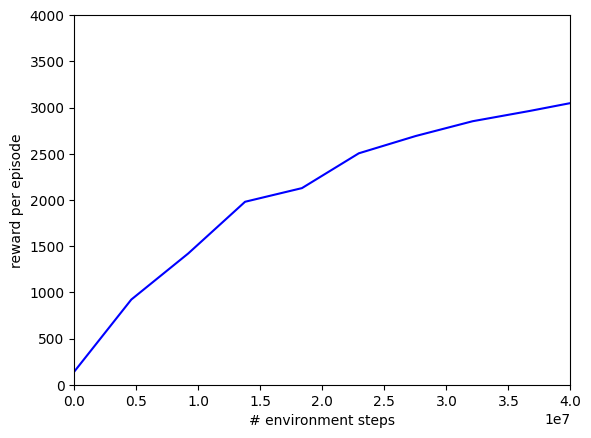

Training (and tracing) done in 202.31 seconds


In [13]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

xdata, ydata = [], []


def progress(step_num, metrics):
    xdata.append(step_num)
    ydata.append(metrics["eval_reward"])
    clear_output(wait=True)

    plt.xlim([0, 40_000_000])
    plt.ylim([0, 4000])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")

    plt.plot(xdata, ydata, "b")
    plt.show()


t0 = time.time()

env = envs.create(env_name="ant", backend="spring")
agent = Agent(jr.PRNGKey(42), env.observation_size, env.action_size)

agent = train(
    agent,
    params=HyperParameters(
        env=env,
        num_timesteps=40_000_000,
        num_evals=10,
        reward_scaling=0.1,
        episode_length=1000,
        unroll_length=5,
        num_minibatches=32,
        num_updates_per_batch=4,
        discounting=0.99,
        learning_rate=3e-4,
        entropy_cost=1e-3,
        batch_size=1024,
        eval_batch_size=256,
        gae_lambda=0.97,
        max_gradient_norm=1.0,
        clipping_epsilon=0.3,
    ),
    progress=progress,
)

print(f"Training (and tracing) done in {time.time() - t0:.2f} seconds")

As the final touch, let's make sure that our algorithm performs on par with some arbitrary, near SOTA, implementation. We are going to compare with the default Brax PPO implementation.

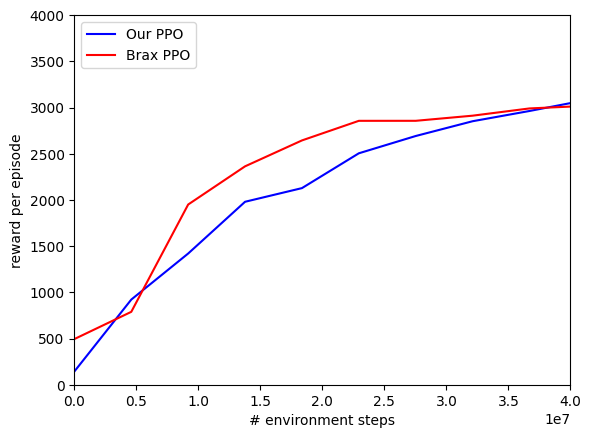

Brax PPO training (and tracing) done in 287.51 seconds


In [14]:
from brax.training.agents.ppo import train as ppo

xdata_brax, ydata_brax = [], []


def progress_brax(step_num, metrics):
    xdata_brax.append(step_num)
    ydata_brax.append(metrics["eval/episode_reward"])
    clear_output(wait=True)

    plt.xlim([0, 40_000_000])
    plt.ylim([0, 4000])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")

    plt.plot(xdata, ydata, "b", label="Our PPO")
    plt.plot(xdata_brax, ydata_brax, "r", label="Brax PPO")
    plt.legend(loc="upper left")
    plt.show()


t0 = time.time()

_ = ppo.train(
    environment=envs.create(env_name="ant", backend="spring"),
    num_timesteps=40_000_000,
    num_evals=10,
    reward_scaling=0.1,
    episode_length=1000,
    unroll_length=5,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.99,
    learning_rate=3e-4,
    entropy_cost=1e-3,
    batch_size=1024,
    gae_lambda=0.97,
    clipping_epsilon=0.3,
    num_envs=1024,
    deterministic_eval=True,
    progress_fn=progress_brax,
)

print(f"Brax PPO training (and tracing) done in {time.time() - t0:.2f} seconds")